In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from mcf.plotting import plot_ensemble_pd
from pygenstability.pygenstability import evaluate_NVI


In [10]:
root_data = "data/240521_"
root_fig = "figures/"
plt.rcParams.update({'font.size': 20})

# Evaluation of MCF ensemble experiments

We evaluate our experiments where we applied MCF to four ensembles of 200 samples from each our models (ER, sSBM, mSBM, nh-mSBM)

## 0) Load data and utils

In [3]:
# load data
with open(root_data+'results_ensemble_er.pkl', 'rb') as handle:
    results_er = pickle.load(handle)
with open(root_data+'results_ensemble_ssbm.pkl', 'rb') as handle:
    results_ssbm = pickle.load(handle)
with open(root_data+'results_ensemble_msbm.pkl', 'rb') as handle:
    results_msbm = pickle.load(handle)
with open(root_data+'results_ensemble_nhmsbm.pkl', 'rb') as handle:
    results_nhmsbm = pickle.load(handle)

In [4]:
# define parameters
min_scale = -1.5
max_scale = 0.5
n_scales = 200
log_scales = np.around(np.linspace(min_scale,max_scale,n_scales),2)
N_REALISATIONS = 200

In [5]:
# reconstruct ground-truth multiscale structure
n0 = int(270)
n1 = 3
n2 = 9
n2_nh = 5
n3 = 27

coarse_scale_id = np.zeros(n0)
middle_scale_id = np.zeros(n0)
middle_scale_nh_id = np.zeros(n0)
fine_scale_id = np.zeros(n0)

for i in range(n1):
    coarse_scale_id[(i * n0 // n1) : ((i + 1) * n0 // n1)] = i

for i in range(n2):
    middle_scale_id[(i * n0 // n2) : ((i + 1) * n0 // n2)] = i

for i in range(n2_nh):
    middle_scale_nh_id[(i * n0 // n2_nh) : ((i + 1) * n0 // n2_nh)] = i

for i in range(n3):
    fine_scale_id[(i * n0 // n3) : ((i + 1) * n0 // n3)] = i

We continue by defining some useful functions to compute confidence intervals and plot ensemble persistence diagrams (PDs).

In [6]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95, digits=3):
    """Computes mean confidence interval for point."""
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return round(m,digits), round(m-h,digits), round(m+h, digits)

In [7]:
def mean_confidence_errorbar(data, confidence=0.95):
    """Computes mean confidence errorbar for line."""
    a = 1.0 * np.array(data)
    m = np.mean(a, axis=0)
    n = len(m)
    se = scipy.stats.sem(a, axis=0)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)

    return m, m-h, m+h

In [8]:
import matplotlib.patches as mpatches

def plot_ensemble_pd(all_persistences, log_times, max_dim=2, alpha=0.1):
    """Code to plot ensemble PD with deaths on x-axis. Modified from GUDHI."""

    # get number of PDs and max dimension
    n_realisations = len(all_persistences)

    # get min and max log_times
    tmin = log_times[0]
    tmax = log_times[-1]

    # compute delta to determine where to plot points at infinity
    delta = 0.1 * abs(tmax - tmin)
    infinity = tmax + 0.5 * delta

    # font size
    plt.rcParams.update({"font.size": 20})

    # create axis
    fig, ax = plt.subplots(1, figsize=(8.4, 7))

    # define colormap
    colormap = plt.cm.Set1.colors

    # infinity line
    ax.plot(
        [infinity, infinity],
        [tmin - 0.5 * delta, tmax],
        
        linewidth=1.0,
        color="k",
        alpha=0.5,
    )

    # plot persistences
    for i in range(n_realisations):
        for dim in range(max_dim + 1):
            persistences = all_persistences[i][dim]
            if i == 0:
                if len(persistences) > 0:
                    ax.scatter(
                        np.nan_to_num(persistences[:, 1], posinf=infinity),
                        persistences[:, 0],
                        
                        color=colormap[dim],
                        alpha=alpha,
                        label=f"$H_{dim}$",
                    )
            else:
                if len(persistences) > 0:
                    ax.scatter(
                        np.nan_to_num(persistences[:, 1],posinf=infinity),
                        persistences[:, 0],
                        
                        color=colormap[dim],
                        alpha=alpha,
                    )

    # plot top line
    ax.plot([tmax, tmax],[tmin - 0.5 * delta, tmax], linewidth=1.0, color="k")

    # plot diag
    ax.plot([tmin, tmax], [tmin, tmax], linewidth=1.0, color="k")

    # plot lower diag patch
    ax.add_patch(
        mpatches.Polygon(
            [[tmin, tmin], [tmin, tmax], [tmax, tmax]], fill=True, color="lightgrey"
        )
    )

    # labels and axes limits
    ax.set(
        xlabel="Death",
        ylabel="Birth",
        xlim=(tmin,infinity + 0.5 * delta),
        ylim = (tmin-0.5*delta, tmax)
    )

    # Infinity and y-axis label
    yt = ax.get_yticks()
    yt = yt[np.where(yt <= tmax)]  # to avoid ploting ticklabel higher than infinity
    yt = np.append(yt, infinity)
    ytl = ["%.2f" % e for e in yt]  # to avoid float precision error
    yt = [-1.5,-1,-0.5,0,0.5,infinity]
    ytl = ["-1.5","-1.0","-0.5","0.0","0.5",r"$\infty$"]
    ax.set_xticks(yt)
    ax.set_xticklabels(ytl)

    # x-axis label
    ax.set_yticks(yt[:-1])
    ax.set_yticklabels(ytl[:-1])

    # create legend for node types
    legend = []
    for dim in range(max_dim + 1):
        legend.append(
            plt.Line2D(
                [0],
                [0],
                marker="o",
                color="w",
                label=f"$H_{dim}$",
                markerfacecolor=colormap[dim],
                markersize=10,
            )
        )
    plt.legend(handles=legend, loc=2, facecolor="white", framealpha=1)

    return fig, ax

## 1) ER ensemble

### 200 ER realisations ###

Mean pair-wise 2-Wasserstein distance for 0-dimensional Dgm:  0.488
Mean pair-wise 2-Wasserstein distance for 1-dimensional Dgm:  3.696
Mean pair-wise 2-Wasserstein distance for 2-dimensional Dgm:  inf


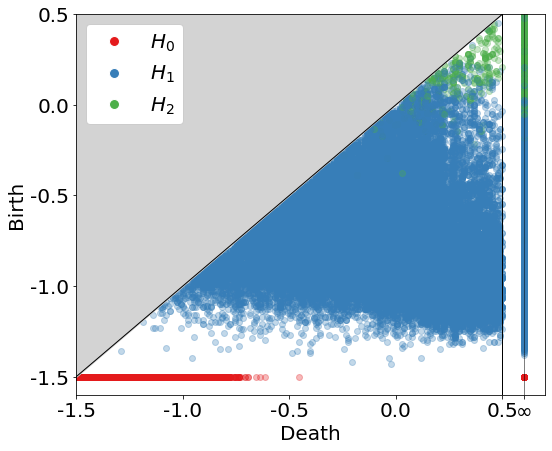

In [126]:
# unpack data
ms_er = results_er['ms_results']
persistence_er = results_er['persistence']
wasserstein_er = results_er['wasserstein']
s_er = np.asarray(results_er["size_partitions"])
b0_er = np.asarray([results_er["bettis"][i][0] for i in range(N_REALISATIONS)])
b1_er = np.asarray([results_er["bettis"][i][1] for i in range(N_REALISATIONS)])
b2_er = np.asarray([results_er["bettis"][i][2] for i in range(N_REALISATIONS)])
h_er = np.asarray(results_er["persistent_hierarchy"])
h_bar_er = np.asarray(results_er["average_persistent_hierarchy"])
c_er = np.asarray(results_er["persistent_conflict"])

# report bottleneck and Wasserstein distance
print(f'### {N_REALISATIONS} ER realisations ###\n')

for i in range(3):  
    print('Mean pair-wise 2-Wasserstein distance for {}-dimensional Dgm: '.format(i), np.around(wasserstein_er[:,:,i].mean(),3))

plt.rcParams.update({'font.size': 20})

# plot PD
ax = plot_ensemble_pd(persistence_er, log_scales, alpha=0.3)
plt.savefig(root_fig +'ensemble_ER_PD.jpeg', bbox_inches='tight')

plt.rcParams.update({'font.size': 20})
    


Average persistent hierarchy: 0.2265 (0.2257--0.2272)


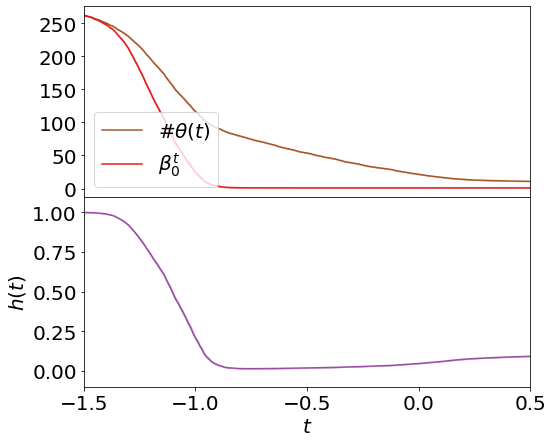

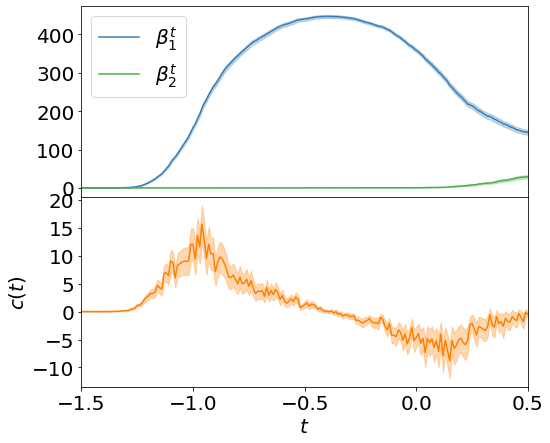

In [130]:
# compute CI errorbars
s_er_m, s_er_l, s_er_r = mean_confidence_errorbar(s_er)
b0_er_m, b0_er_l, b0_er_r = mean_confidence_errorbar(b0_er)
h_er_m, h_er_l, h_er_r = mean_confidence_errorbar(h_er)
b1_er_m, b1_er_l, b1_er_r = mean_confidence_errorbar(b1_er)
b2_er_m, b2_er_l, b2_er_r = mean_confidence_errorbar(b2_er)
c_er_m, c_er_l, c_er_r = mean_confidence_errorbar(c_er)

# plot persistent hierarchy and conflict
colormap = plt.cm.Set1.colors

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.fill_between(log_scales, s_er_l, s_er_r, alpha=0.3, color=colormap[6])
ax1.plot(log_scales,s_er_m, label = r'$\#\theta(t)$', color=colormap[6])

ax1.fill_between(log_scales, b0_er_l, b0_er_r, alpha=0.3, color=colormap[0])
ax1.plot(log_scales,b0_er_m, label = r'$\beta_0^t$', color=colormap[0])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=3)
ax2.fill_between(log_scales, h_er_l, h_er_r, alpha=0.3, color=colormap[3])
ax2.plot(log_scales,h_er_m, label = r'$h(t)$',c=colormap[3])
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$t$',ylim=(-0.1,1.1),xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=6) 
ax2.locator_params(axis='y', nbins=6) 
plt.savefig(root_fig +'ensemble_ER_hierarchy-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

h_bar_er_m, h_bar_er_l, h_bar_er_r = mean_confidence_interval(h_bar_er, digits=4)

print(f"\nAverage persistent hierarchy: {h_bar_er_m} ({h_bar_er_l}--{h_bar_er_r})")

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.fill_between(log_scales, b1_er_l, b1_er_r, alpha=0.3, color=colormap[1])
ax1.plot(log_scales,b1_er_m, label = r'$\beta_1^t$', color=colormap[1])
ax1.fill_between(log_scales, b2_er_l, b2_er_r, alpha=0.3, color=colormap[2])
ax1.plot(log_scales,b2_er_m, label = r'$\beta_2^t$',color=colormap[2])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=2)

ax2.fill_between(log_scales, c_er_l, c_er_r, alpha=0.3, color=colormap[4])
ax2.plot(log_scales,c_er_m,c=colormap[4])
ax2.set_ylabel(r'$c(t)$')
ax2.set(xlabel=r'$t$',xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=6) 
ax2.locator_params(axis='y', nbins=7) 
plt.savefig(root_fig +'ensemble_ER_conflict-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

## 2) sSBM ensemble

### 200 sSBM realisations ###

Mean pair-wise 2-Wasserstein distance for 0-dimensional Dgm:  0.456
Mean pair-wise 2-Wasserstein distance for 1-dimensional Dgm:  1.406
Mean pair-wise 2-Wasserstein distance for 2-dimensional Dgm:  0.424


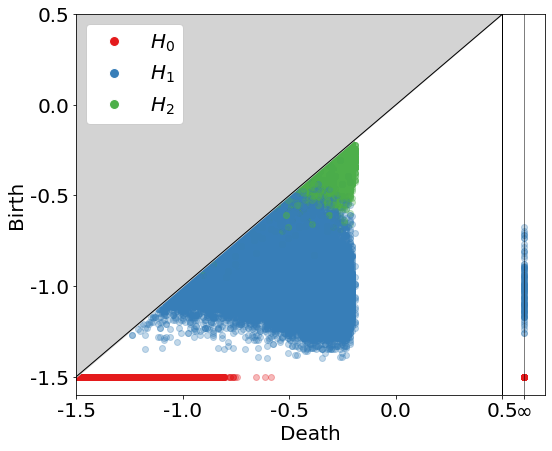

In [127]:
# unpack data
ms_ssbm = results_ssbm['ms_results']
permutations_ssbm = results_ssbm['permutations']
persistence_ssbm = results_ssbm['persistence']
wasserstein_ssbm = results_ssbm['wasserstein']
s_ssbm = np.asarray(results_ssbm["size_partitions"])
b0_ssbm = np.asarray([results_ssbm["bettis"][i][0] for i in range(N_REALISATIONS)])
b1_ssbm = np.asarray([results_ssbm["bettis"][i][1] for i in range(N_REALISATIONS)])
b2_ssbm = np.asarray([results_ssbm["bettis"][i][2] for i in range(N_REALISATIONS)])
h_ssbm = np.asarray(results_ssbm["persistent_hierarchy"])
h_bar_ssbm = np.asarray(results_ssbm["average_persistent_hierarchy"])
c_ssbm = np.asarray(results_ssbm["persistent_conflict"])

# report bottleneck and Wasserstein distance
print(f'### {N_REALISATIONS} sSBM realisations ###\n')

for i in range(3):  
    print('Mean pair-wise 2-Wasserstein distance for {}-dimensional Dgm: '.format(i), np.around(wasserstein_ssbm[:,:,i].mean(),3))

# plot PD
ax = plot_ensemble_pd(persistence_ssbm, log_scales, alpha=0.3)
plt.savefig(root_fig +'ensemble_sSBM_PD.jpeg', bbox_inches='tight') 

In [132]:
# compare MS partitions to fine ground truth with NVI
nvi_coarse_ssbm = np.zeros((N_REALISATIONS, n_scales))

for j in range(N_REALISATIONS):
    nvi_coarse_ssbm[j] = np.array(
        [
            evaluate_NVI([0, i], [coarse_scale_id[permutations_ssbm[j]]] + ms_ssbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

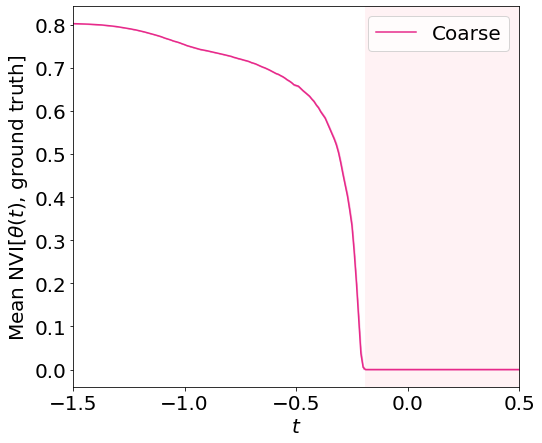

In [133]:
# determine are where close to ground truth
coarse_ind_ssbm = np.where(nvi_coarse_ssbm.mean(axis=0)<=nvi_coarse_ssbm.mean(axis=0).min()+0.001)[0]

# compute CI errorbars
nvi_coarse_ssbm_m, nvi_coarse_ssbm_l, nvi_coarse_ssbm_r = mean_confidence_errorbar(nvi_coarse_ssbm)

# plot
colormap = plt.cm.Dark2.colors
fig, ax = plt.subplots(1, figsize=(8,7))

ax.axvspan(log_scales[coarse_ind_ssbm[0]],log_scales[coarse_ind_ssbm[-1]], facecolor='pink', alpha=0.2)
ax.fill_between(log_scales, nvi_coarse_ssbm_l, nvi_coarse_ssbm_r, alpha=0.3, color=colormap[3])
ax.plot(log_scales, nvi_coarse_ssbm_m,label="Coarse", color=colormap[3])

ax.set(xlabel="$t$",ylabel=r"Mean NVI[$\theta(t)$, ground truth]",xlim=(log_scales[0],log_scales[-1]))
ax.legend(loc=1)
plt.savefig(root_fig +'ensemble_sSBM_NVI.pdf', bbox_inches='tight')
plt.show()


Average persistent hierarchy: 0.436 (0.421--0.45)


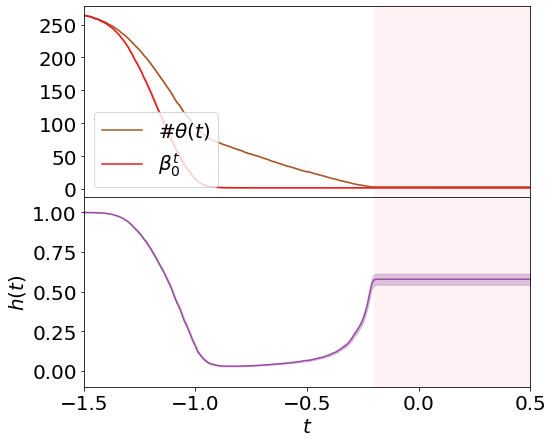

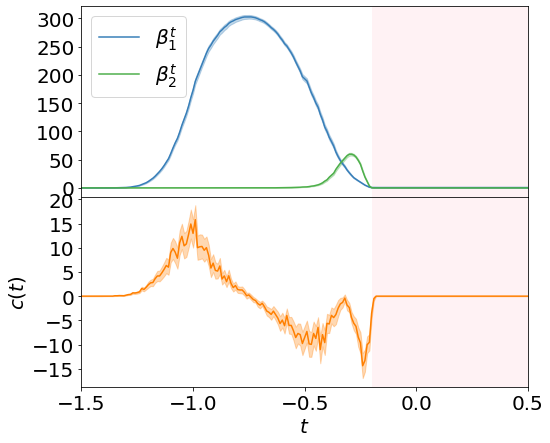

In [134]:
# determine are where close to ground truth
coarse_ind_ssbm = np.where(nvi_coarse_ssbm.mean(axis=0)<=nvi_coarse_ssbm.mean(axis=0).min()+0.01)[0]

# compute CI errorbars
s_ssbm_m, s_ssbm_l, s_ssbm_r = mean_confidence_errorbar(s_ssbm)
b0_ssbm_m, b0_ssbm_l, b0_ssbm_r = mean_confidence_errorbar(b0_ssbm)
h_ssbm_m, h_ssbm_l, h_ssbm_r = mean_confidence_errorbar(h_ssbm)
b1_ssbm_m, b1_ssbm_l, b1_ssbm_r = mean_confidence_errorbar(b1_ssbm)
b2_ssbm_m, b2_ssbm_l, b2_ssbm_r = mean_confidence_errorbar(b2_ssbm)
c_ssbm_m, c_ssbm_l, c_ssbm_r = mean_confidence_errorbar(c_ssbm)

# plot persistent hierarchy and conflict
colormap = plt.cm.Set1.colors

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.axvspan(log_scales[coarse_ind_ssbm[0]],log_scales[coarse_ind_ssbm[-1]], facecolor='pink', alpha=0.2)
ax1.fill_between(log_scales, s_ssbm_l, s_ssbm_r, alpha=0.3, color=colormap[6])
ax1.plot(log_scales,s_ssbm_m, label = r'$\#\theta(t)$', color=colormap[6])

ax1.fill_between(log_scales, b0_ssbm_l, b0_ssbm_r, alpha=0.3, color=colormap[0])
ax1.plot(log_scales,b0_ssbm_m, label = r'$\beta_0^t$', color=colormap[0])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=3)
ax2.axvspan(log_scales[coarse_ind_ssbm[0]],log_scales[coarse_ind_ssbm[-1]], facecolor='pink', alpha=0.2)
ax2.fill_between(log_scales, h_ssbm_l, h_ssbm_r, alpha=0.3, color=colormap[3])
ax2.plot(log_scales,h_ssbm_m, label = r'$h(t)$',c=colormap[3])
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$t$',ylim=(-0.1,1.1),xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=6) 
ax2.locator_params(axis='y', nbins=6) 
plt.savefig(root_fig +'ensemble_sSBM_hierarchy-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

h_bar_ssbm_m, h_bar_ssbm_l, h_bar_ssbm_r = mean_confidence_interval(h_bar_ssbm, digits=3)

print(f"\nAverage persistent hierarchy: {h_bar_ssbm_m} ({h_bar_ssbm_l}--{h_bar_ssbm_r})")

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.axvspan(log_scales[coarse_ind_ssbm[0]],log_scales[coarse_ind_ssbm[-1]], facecolor='pink', alpha=0.2)
ax1.fill_between(log_scales, b1_ssbm_l, b1_ssbm_r, alpha=0.3, color=colormap[1])
ax1.plot(log_scales,b1_ssbm_m, label = r'$\beta_1^t$', color=colormap[1])
ax1.fill_between(log_scales, b2_ssbm_l, b2_ssbm_r, alpha=0.3, color=colormap[2])
ax1.plot(log_scales,b2_ssbm_m, label = r'$\beta_2^t$',color=colormap[2])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=2)

ax2.axvspan(log_scales[coarse_ind_ssbm[0]],log_scales[coarse_ind_ssbm[-1]], facecolor='pink', alpha=0.2)
ax2.fill_between(log_scales, c_ssbm_l, c_ssbm_r, alpha=0.3, color=colormap[4])
ax2.plot(log_scales,c_ssbm_m,c=colormap[4])
ax2.set_ylabel(r'$c(t)$')
ax2.set(xlabel=r'$t$',xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=7) 
ax2.locator_params(axis='y', nbins=8) 
plt.savefig(root_fig +'ensemble_sSBM_conflict-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

## 3) mSBM ensemble

### 200 mSBM realisations ###

Mean pair-wise 2-Wasserstein distance for 0-dimensional Dgm:  0.964
Mean pair-wise 2-Wasserstein distance for 1-dimensional Dgm:  1.179
Mean pair-wise 2-Wasserstein distance for 2-dimensional Dgm:  0.004


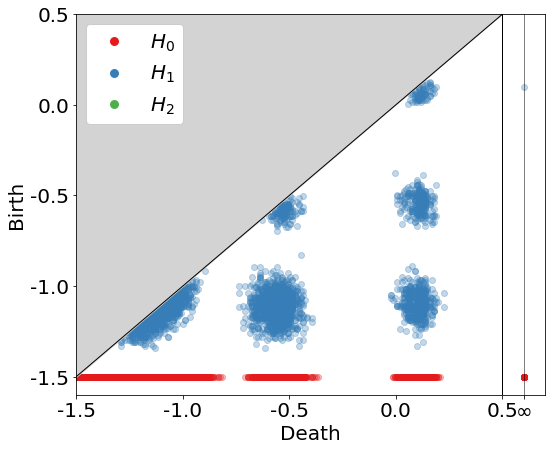

In [128]:
# unpack data
ms_msbm = results_msbm['ms_results']
permutations_msbm = results_msbm['permutations']
persistence_msbm = results_msbm['persistence']
wasserstein_msbm = results_msbm['wasserstein']
s_msbm = np.asarray(results_msbm["size_partitions"])
b0_msbm = np.asarray([results_msbm["bettis"][i][0] for i in range(N_REALISATIONS)])
b1_msbm = np.asarray([results_msbm["bettis"][i][1] for i in range(N_REALISATIONS)])
b2_msbm = np.asarray([results_msbm["bettis"][i][2] for i in range(N_REALISATIONS)])
h_msbm = np.asarray(results_msbm["persistent_hierarchy"])
h_bar_msbm = np.asarray(results_msbm["average_persistent_hierarchy"])
c_msbm = np.asarray(results_msbm["persistent_conflict"])

# report bottleneck and Wasserstein distance
print(f'### {N_REALISATIONS} mSBM realisations ###\n')

for i in range(3):  
    print('Mean pair-wise 2-Wasserstein distance for {}-dimensional Dgm: '.format(i), np.around(wasserstein_msbm[:,:,i].mean(),3))

# plot PD
ax = plot_ensemble_pd(persistence_msbm, log_scales, alpha=0.3)
plt.savefig(root_fig +'ensemble_mSBM_PD.jpeg', bbox_inches='tight')
    

In [135]:
# compare MS partitions to fine ground truth with NVI
nvi_fine_msbm = np.zeros((N_REALISATIONS, n_scales))

for j in tqdm(range(N_REALISATIONS)):
    nvi_fine_msbm[j] = np.array(
        [
            evaluate_NVI([0, i], [fine_scale_id[permutations_msbm[j]]] + ms_msbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

# compare MS partitions to middle ground truth with NVI
nvi_middle_msbm = np.zeros((N_REALISATIONS, n_scales))

for j in tqdm(range(N_REALISATIONS)):
    nvi_middle_msbm[j] = np.array(
        [
            evaluate_NVI([0, i], [middle_scale_id[permutations_msbm[j]]] + ms_msbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

# compare MS partitions to coarse ground truth with NVI
nvi_coarse_msbm = np.zeros((N_REALISATIONS, n_scales))

for j in tqdm(range(N_REALISATIONS)):
    nvi_coarse_msbm[j] = np.array(
        [
            evaluate_NVI([0, i], [coarse_scale_id[permutations_msbm[j]]] + ms_msbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

100%|██████████| 200/200 [00:51<00:00,  3.92it/s]


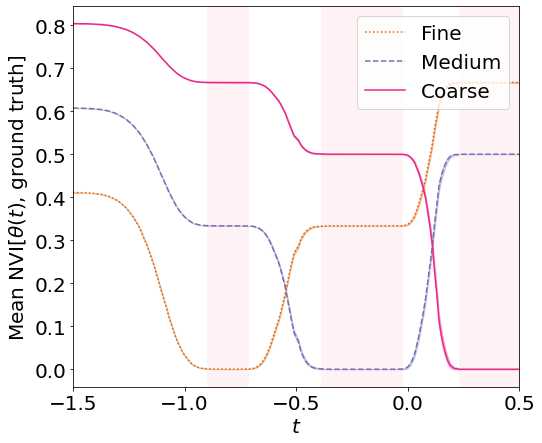

In [136]:
# determine where close to ground truth
fine_ind_msbm = np.where(nvi_fine_msbm.mean(axis=0)<=nvi_fine_msbm.mean(axis=0).min()+0.001)[0]
middle_ind_msbm = np.where(nvi_middle_msbm.mean(axis=0)<=nvi_middle_msbm.mean(axis=0).min()+0.001)[0]
coarse_ind_msbm = np.where(nvi_coarse_msbm.mean(axis=0)<=nvi_coarse_msbm.mean(axis=0).min()+0.001)[0]


# compute CI errorbars
nvi_fine_msbm_m, nvi_fine_msbm_l, nvi_fine_msbm_r = mean_confidence_errorbar(nvi_fine_msbm)
nvi_middle_msbm_m, nvi_middle_msbm_l, nvi_middle_msbm_r = mean_confidence_errorbar(nvi_middle_msbm)
nvi_coarse_msbm_m, nvi_coarse_msbm_l, nvi_coarse_msbm_r = mean_confidence_errorbar(nvi_coarse_msbm)

# plot
colormap = plt.cm.Dark2.colors
fig, ax = plt.subplots(1, figsize=(8,7))

ax.axvspan(log_scales[fine_ind_msbm[0]],log_scales[fine_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax.axvspan(log_scales[middle_ind_msbm[0]],log_scales[middle_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax.axvspan(log_scales[coarse_ind_msbm[0]],log_scales[coarse_ind_msbm[-1]], facecolor='pink', alpha=0.2)

ax.fill_between(log_scales, nvi_fine_msbm_l, nvi_fine_msbm_r, alpha=0.3, color=colormap[1])
ax.plot(log_scales, nvi_fine_msbm_m,label="Fine", color=colormap[1], ls=":")

ax.fill_between(log_scales, nvi_middle_msbm_l, nvi_middle_msbm_r, alpha=0.3, color=colormap[2])
ax.plot(log_scales, nvi_middle_msbm_m,label="Medium", color=colormap[2], ls="--")

ax.fill_between(log_scales, nvi_coarse_msbm_l, nvi_coarse_msbm_r, alpha=0.3, color=colormap[3])
ax.plot(log_scales, nvi_coarse_msbm_m,label="Coarse", color=colormap[3])

ax.set(xlabel="$t$",ylabel=r"Mean NVI[$\theta(t)$, ground truth]",xlim=(log_scales[0],log_scales[-1]))
ax.legend(loc=1)
plt.savefig(root_fig +'ensemble_mSBM_NVI.pdf', bbox_inches='tight')
plt.show()


Average persistent hierarchy: 0.643 (0.631--0.655)


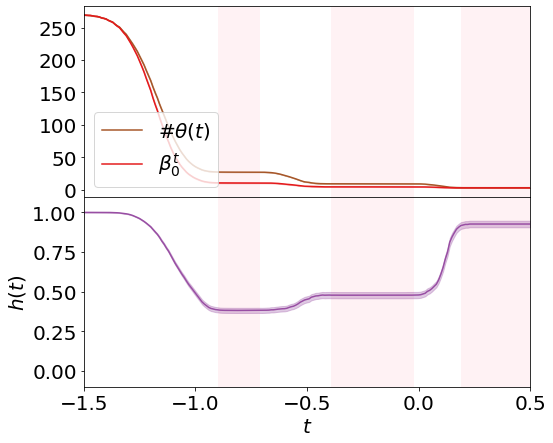

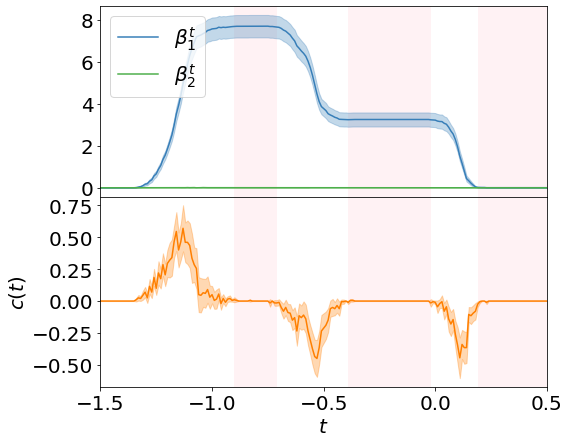

In [137]:
# determine are where close to ground truth
fine_ind_msbm = np.where(nvi_fine_msbm.mean(axis=0)<=nvi_fine_msbm.mean(axis=0).min()+0.001)[0]
middle_ind_msbm = np.where(nvi_middle_msbm.mean(axis=0)<=nvi_middle_msbm.mean(axis=0).min()+0.001)[0]
coarse_ind_msbm = np.where(nvi_coarse_msbm.mean(axis=0)<=nvi_coarse_msbm.mean(axis=0).min()+0.01)[0]

# compute CI errorbars
s_msbm_m, s_msbm_l, s_msbm_r = mean_confidence_errorbar(s_msbm)
b0_msbm_m, b0_msbm_l, b0_msbm_r = mean_confidence_errorbar(b0_msbm)
h_msbm_m, h_msbm_l, h_msbm_r = mean_confidence_errorbar(h_msbm)
b1_msbm_m, b1_msbm_l, b1_msbm_r = mean_confidence_errorbar(b1_msbm)
b2_msbm_m, b2_msbm_l, b2_msbm_r = mean_confidence_errorbar(b2_msbm)
c_msbm_m, c_msbm_l, c_msbm_r = mean_confidence_errorbar(c_msbm)

# plot persistent hierarchy and conflict
colormap = plt.cm.Set1.colors

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.axvspan(log_scales[fine_ind_msbm[0]],log_scales[fine_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[middle_ind_msbm[0]],log_scales[middle_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[coarse_ind_msbm[0]],log_scales[coarse_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax1.fill_between(log_scales, s_msbm_l, s_msbm_r, alpha=0.3, color=colormap[6])
ax1.plot(log_scales,s_msbm_m, label = r'$\#\theta(t)$', color=colormap[6])
ax1.fill_between(log_scales, b0_msbm_l, b0_msbm_r, alpha=0.3, color=colormap[0])
ax1.plot(log_scales,b0_msbm_m, label = r'$\beta_0^t$', color=colormap[0])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=3)

ax2.axvspan(log_scales[fine_ind_msbm[0]],log_scales[fine_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[middle_ind_msbm[0]],log_scales[middle_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[coarse_ind_msbm[0]],log_scales[coarse_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax2.fill_between(log_scales, h_msbm_l, h_msbm_r, alpha=0.3, color=colormap[3])
ax2.plot(log_scales,h_msbm_m, label = r'$h(t)$',c=colormap[3])
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$t$',ylim=(-0.1,1.1),xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=4) 
ax2.locator_params(axis='y', nbins=4) 
ax1.locator_params(axis='y', nbins=6) 
ax2.locator_params(axis='y', nbins=6) 
plt.savefig(root_fig +'ensemble_mSBM_hierarchy-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

h_bar_msbm_m, h_bar_msbm_l, h_bar_msbm_r = mean_confidence_interval(h_bar_msbm, digits=3)

print(f"\nAverage persistent hierarchy: {h_bar_msbm_m} ({h_bar_msbm_l}--{h_bar_msbm_r})")

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.axvspan(log_scales[fine_ind_msbm[0]],log_scales[fine_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[middle_ind_msbm[0]],log_scales[middle_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[coarse_ind_msbm[0]],log_scales[coarse_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax1.fill_between(log_scales, b1_msbm_l, b1_msbm_r, alpha=0.3, color=colormap[1])
ax1.plot(log_scales,b1_msbm_m, label = r'$\beta_1^t$', color=colormap[1])
ax1.fill_between(log_scales, b2_msbm_l, b2_msbm_r, alpha=0.3, color=colormap[2])
ax1.plot(log_scales,b2_msbm_m, label = r'$\beta_2^t$',color=colormap[2])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=2)

ax2.axvspan(log_scales[fine_ind_msbm[0]],log_scales[fine_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[middle_ind_msbm[0]],log_scales[middle_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[coarse_ind_msbm[0]],log_scales[coarse_ind_msbm[-1]], facecolor='pink', alpha=0.2)
ax2.fill_between(log_scales, c_msbm_l, c_msbm_r, alpha=0.3, color=colormap[4])
ax2.plot(log_scales,c_msbm_m,c=colormap[4])
ax2.set_ylabel(r'$c(t)$')
ax2.set(xlabel=r'$t$',xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=5) 
ax2.locator_params(axis='y', nbins=6) 
plt.savefig(root_fig +'ensemble_mSBM_conflict-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

## 4) nhmSBM ensemble

### 200 mSBM realisations ###

Mean pair-wise 2-Wasserstein distance for 0-dimensional Dgm:  0.701
Mean pair-wise 2-Wasserstein distance for 1-dimensional Dgm:  1.764
Mean pair-wise 2-Wasserstein distance for 2-dimensional Dgm:  0.023


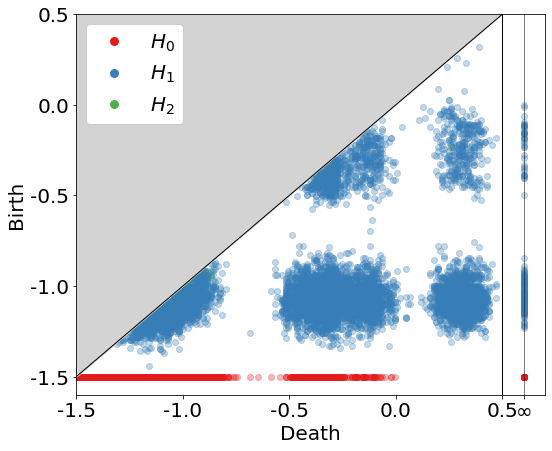

In [129]:
# unpack data
ms_nhmsbm = results_nhmsbm['ms_results']
permutations_nhmsbm = results_nhmsbm['permutations']
persistence_nhmsbm = results_nhmsbm['persistence']
wasserstein_nhmsbm = results_nhmsbm['wasserstein']
s_nhmsbm = np.asarray(results_nhmsbm["size_partitions"])
b0_nhmsbm = np.asarray([results_nhmsbm["bettis"][i][0] for i in range(N_REALISATIONS)])
b1_nhmsbm = np.asarray([results_nhmsbm["bettis"][i][1] for i in range(N_REALISATIONS)])
b2_nhmsbm = np.asarray([results_nhmsbm["bettis"][i][2] for i in range(N_REALISATIONS)])
h_nhmsbm = np.asarray(results_nhmsbm["persistent_hierarchy"])
h_bar_nhmsbm = np.asarray(results_nhmsbm["average_persistent_hierarchy"])
c_nhmsbm = np.asarray(results_nhmsbm["persistent_conflict"])

# report bottleneck and Wasserstein distance
print(f'### {N_REALISATIONS} mSBM realisations ###\n')

for i in range(3):  
    print('Mean pair-wise 2-Wasserstein distance for {}-dimensional Dgm: '.format(i), np.around(wasserstein_nhmsbm[:,:,i].mean(),3))

# plot PD
ax = plot_ensemble_pd(persistence_nhmsbm, log_scales, alpha=0.3)
plt.savefig(root_fig +'ensemble_nh_mSBM_PD.jpeg', bbox_inches='tight')

In [138]:
# compare MS partitions to fine ground truth with NVI
nvi_fine_nhmsbm = np.zeros((N_REALISATIONS, n_scales))

for j in tqdm(range(N_REALISATIONS)):
    nvi_fine_nhmsbm[j] = np.array(
        [
            evaluate_NVI([0, i], [fine_scale_id[permutations_nhmsbm[j]]] + ms_nhmsbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

# compare MS partitions to middle ground truth with NVI
nvi_middle_nhmsbm = np.zeros((N_REALISATIONS, n_scales))

for j in tqdm(range(N_REALISATIONS)):
    nvi_middle_nhmsbm[j] = np.array(
        [
            evaluate_NVI([0, i], [middle_scale_nh_id[permutations_nhmsbm[j]]] + ms_nhmsbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

# compare MS partitions to coarse ground truth with NVI
nvi_coarse_nhmsbm = np.zeros((N_REALISATIONS, n_scales))

for j in tqdm(range(N_REALISATIONS)):
    nvi_coarse_nhmsbm[j] = np.array(
        [
            evaluate_NVI([0, i], [coarse_scale_id[permutations_nhmsbm[j]]] + ms_nhmsbm[j]["community_id"])
            for i in range(1, n_scales + 1)
        ]
    )

100%|██████████| 200/200 [00:56<00:00,  3.54it/s]


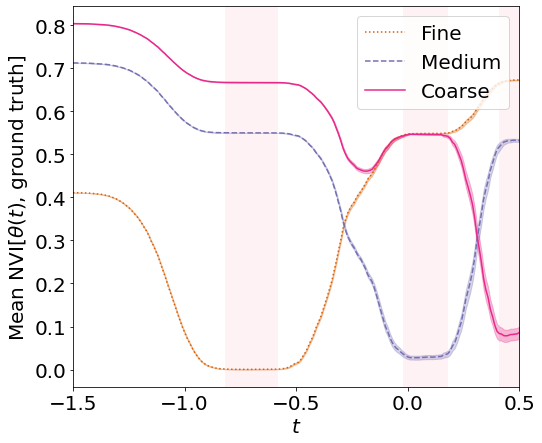

In [139]:
# determine where close to ground truth
fine_ind_nhmsbm = np.where(nvi_fine_nhmsbm.mean(axis=0)<=nvi_fine_nhmsbm.mean(axis=0).min()+0.001)[0]
middle_ind_nhmsbm = np.where(nvi_middle_nhmsbm.mean(axis=0)<=nvi_middle_nhmsbm.mean(axis=0).min()+0.01)[0]
coarse_ind_nhmsbm = np.where(nvi_coarse_nhmsbm.mean(axis=0)<=nvi_coarse_nhmsbm.mean(axis=0).min()+0.01)[0]

# compute CI errorbars
nvi_fine_nhmsbm_m, nvi_fine_nhmsbm_l, nvi_fine_nhmsbm_r = mean_confidence_errorbar(nvi_fine_nhmsbm)
nvi_middle_nhmsbm_m, nvi_middle_nhmsbm_l, nvi_middle_nhmsbm_r = mean_confidence_errorbar(nvi_middle_nhmsbm)
nvi_coarse_nhmsbm_m, nvi_coarse_nhmsbm_l, nvi_coarse_nhmsbm_r = mean_confidence_errorbar(nvi_coarse_nhmsbm)

# plot
colormap = plt.cm.Dark2.colors
fig, ax = plt.subplots(1, figsize=(8,7))

ax.axvspan(log_scales[fine_ind_nhmsbm[0]],log_scales[fine_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax.axvspan(log_scales[middle_ind_nhmsbm[0]],log_scales[middle_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax.axvspan(log_scales[coarse_ind_nhmsbm[0]],log_scales[coarse_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)

ax.fill_between(log_scales, nvi_fine_nhmsbm_l, nvi_fine_nhmsbm_r, alpha=0.3, color=colormap[1])
ax.plot(log_scales, nvi_fine_nhmsbm_m,label="Fine", color=colormap[1], ls=":")

ax.fill_between(log_scales, nvi_middle_nhmsbm_l, nvi_middle_nhmsbm_r, alpha=0.3, color=colormap[2])
ax.plot(log_scales, nvi_middle_nhmsbm_m,label="Medium", color=colormap[2], ls="--")

ax.fill_between(log_scales, nvi_coarse_nhmsbm_l, nvi_coarse_nhmsbm_r, alpha=0.3, color=colormap[3])
ax.plot(log_scales, nvi_coarse_nhmsbm_m,label="Coarse", color=colormap[3])

ax.set(xlabel="$t$",ylabel=r"Mean NVI[$\theta(t)$, ground truth]",xlim=(log_scales[0],log_scales[-1]))
ax.legend(loc=1)
plt.savefig(root_fig +'ensemble_nh_mSBM_NVI.pdf', bbox_inches='tight')
plt.show()




Average persistent hierarchy: 0.325 (0.322--0.329)


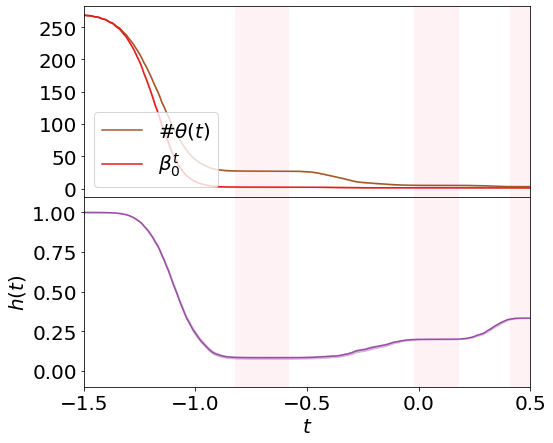

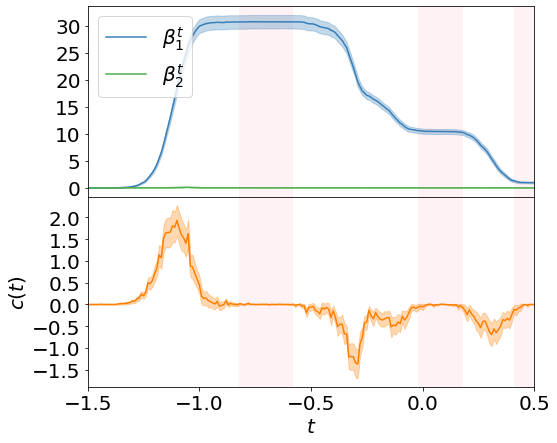

In [140]:
# determine are where close to ground truth
fine_ind_nhmsbm = np.where(nvi_fine_nhmsbm.mean(axis=0)<=nvi_fine_nhmsbm.mean(axis=0).min()+0.001)[0]
middle_ind_nhmsbm = np.where(nvi_middle_nhmsbm.mean(axis=0)<=nvi_middle_nhmsbm.mean(axis=0).min()+0.01)[0]
coarse_ind_nhmsbm = np.where(nvi_coarse_nhmsbm.mean(axis=0)<=nvi_coarse_nhmsbm.mean(axis=0).min()+0.01)[0]

# compute CI errorbars
s_nhmsbm_m, s_nhmsbm_l, s_nhmsbm_r = mean_confidence_errorbar(s_nhmsbm)
b0_nhmsbm_m, b0_nhmsbm_l, b0_nhmsbm_r = mean_confidence_errorbar(b0_nhmsbm)
h_nhmsbm_m, h_nhmsbm_l, h_nhmsbm_r = mean_confidence_errorbar(h_nhmsbm)
b1_nhmsbm_m, b1_nhmsbm_l, b1_nhmsbm_r = mean_confidence_errorbar(b1_nhmsbm)
b2_nhmsbm_m, b2_nhmsbm_l, b2_nhmsbm_r = mean_confidence_errorbar(b2_nhmsbm)
c_nhmsbm_m, c_nhmsbm_l, c_nhmsbm_r = mean_confidence_errorbar(c_nhmsbm)

# plot persistent hierarchy and conflict
colormap = plt.cm.Set1.colors

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.axvspan(log_scales[fine_ind_nhmsbm[0]],log_scales[fine_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[middle_ind_nhmsbm[0]],log_scales[middle_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[coarse_ind_nhmsbm[0]],log_scales[coarse_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax1.fill_between(log_scales, s_nhmsbm_l, s_nhmsbm_r, alpha=0.3, color=colormap[6])
ax1.plot(log_scales,s_nhmsbm_m, label = r'$\#\theta(t)$', color=colormap[6])
ax1.fill_between(log_scales, b0_nhmsbm_l, b0_nhmsbm_r, alpha=0.3, color=colormap[0])
ax1.plot(log_scales,b0_nhmsbm_m, label = r'$\beta_0^t$', color=colormap[0])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=3)

ax2.axvspan(log_scales[fine_ind_nhmsbm[0]],log_scales[fine_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[middle_ind_nhmsbm[0]],log_scales[middle_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[coarse_ind_nhmsbm[0]],log_scales[coarse_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax2.fill_between(log_scales, h_nhmsbm_l, h_nhmsbm_r, alpha=0.3, color=colormap[3])
ax2.plot(log_scales,h_nhmsbm_m, label = r'$h(t)$',c=colormap[3])
ax2.set_ylabel(r'$h(t)$')
ax2.set(xlabel=r'$t$',ylim=(-0.1,1.1),xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=6) 
ax2.locator_params(axis='y', nbins=6) 
plt.savefig(root_fig +'ensemble_nh_mSBM_hierarchy-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

h_bar_nhmsbm_m, h_bar_nhmsbm_l, h_bar_nhmsbm_r = mean_confidence_interval(h_bar_nhmsbm, digits=3)

print(f"\nAverage persistent hierarchy: {h_bar_nhmsbm_m} ({h_bar_nhmsbm_l}--{h_bar_nhmsbm_r})")

fig, axs = plt.subplots(2, figsize=(8, 7))
fig.subplots_adjust(hspace=0.0, wspace=0.3)
ax1 = axs[0]
ax2 = axs[1]
ax1.axvspan(log_scales[fine_ind_nhmsbm[0]],log_scales[fine_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[middle_ind_nhmsbm[0]],log_scales[middle_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax1.axvspan(log_scales[coarse_ind_nhmsbm[0]],log_scales[coarse_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax1.fill_between(log_scales, b1_nhmsbm_l, b1_nhmsbm_r, alpha=0.3, color=colormap[1])
ax1.plot(log_scales,b1_nhmsbm_m, label = r'$\beta_1^t$', color=colormap[1])
ax1.fill_between(log_scales, b2_nhmsbm_l, b2_nhmsbm_r, alpha=0.3, color=colormap[2])
ax1.plot(log_scales,b2_nhmsbm_m, label = r'$\beta_2^t$',color=colormap[2])
ax1.set(xticks=[],xlim=(log_scales[0],log_scales[-1]))
ax1.legend(loc=2)

ax2.axvspan(log_scales[fine_ind_nhmsbm[0]],log_scales[fine_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[middle_ind_nhmsbm[0]],log_scales[middle_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax2.axvspan(log_scales[coarse_ind_nhmsbm[0]],log_scales[coarse_ind_nhmsbm[-1]], facecolor='pink', alpha=0.2)
ax2.fill_between(log_scales, c_nhmsbm_l, c_nhmsbm_r, alpha=0.3, color=colormap[4])
ax2.plot(log_scales,c_nhmsbm_m,c=colormap[4])
ax2.set_ylabel(r'$c(t)$')
ax2.set(xlabel=r'$t$',xlim=(log_scales[0],log_scales[-1]))
ax1.locator_params(axis='y', nbins=8) 
ax2.locator_params(axis='y', nbins=9) 
plt.savefig(root_fig +'ensemble_nh_mSBM_conflict-CI.pdf', dpi=fig.dpi,bbox_inches='tight')

# Visual analysis of pairwise distances

## Pairwise Wasserstein distance of PDs

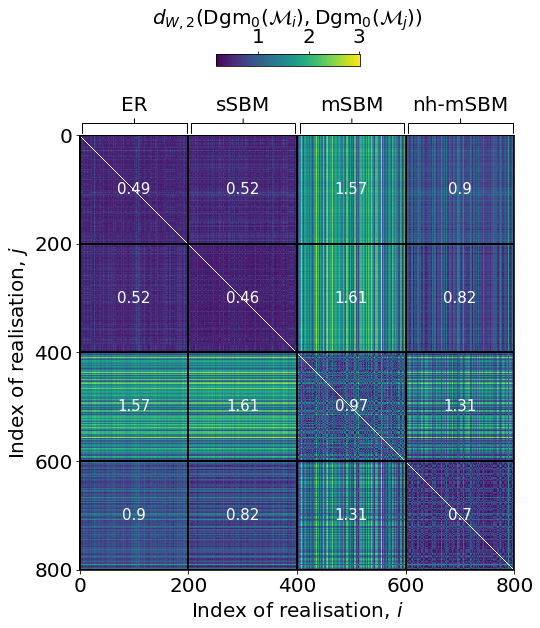

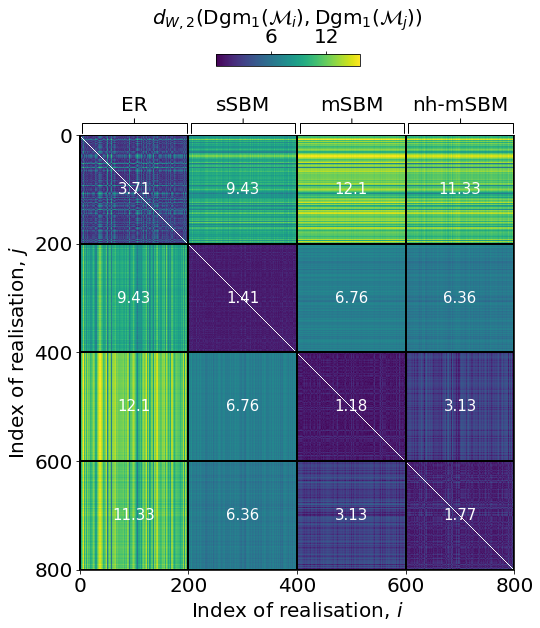

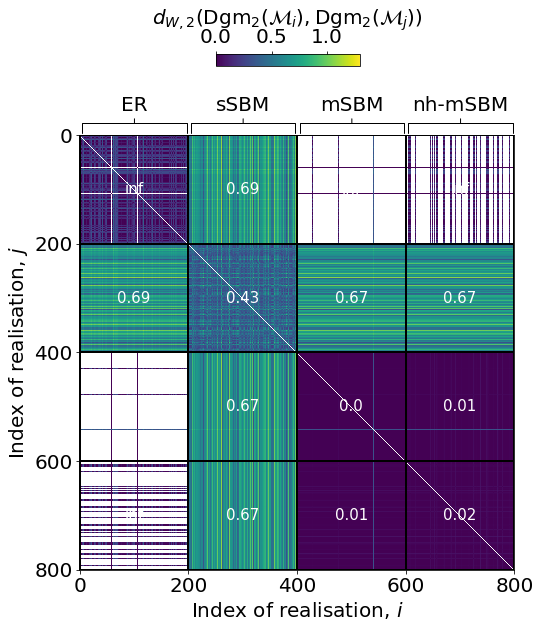

In [11]:
# load pairwise Wasserstein distances
wasserstein_distances = np.load(root_data+"results_comparison_wasserstein.npy")

# plot distance matrices for different dimensions of PDs
for i in range(3):
    W = wasserstein_distances[:,:,i]

    for j in range(W.shape[0]):
        W[j,j] = np.NaN

    # compute mean values for each group
    W_mean = np.zeros((4,4))
    for k in range(4):
        for j in range(4):
            W_mean[k,j] = np.around(np.nanmean(W[k*200:(k+1)*200,j*200:(j+1)*200]),2)

    fig, ax = plt.subplots(1,figsize =(10,8))
    im = ax.matshow(W)
    # Add grid lines every 200 units
    plt.grid(which='both', color='black', linewidth=2)
    ax.set(xlabel="Index of realisation, $i$", ylabel="Index of realisation, $j$",xticks=np.arange(0,801,200),xticklabels=np.arange(0,801,200),yticks=np.arange(0,801,200),yticklabels=np.arange(0,801,200))

    ax.xaxis.set_label_position('bottom')
    ax.xaxis.set_ticks_position('bottom')

    # Add text annotations at the center of each block
    for k in range(4):
        for j in range(4):
            plt.text(j*200 + 100, k*200 + 100, W_mean[k,j], color='white',
                    ha='center', va='center', fontsize=15)

    # Add curly brackets to the x-axis
    for j in range(4):
        model_name = ["ER","sSBM","mSBM","nh-mSBM"]
        ax.annotate(model_name[j], xy=(55+j*108.7,445), xycoords='axes points',
                    xytext=(0, 10), ha='center', va='bottom', textcoords='offset points',
                    arrowprops=dict(arrowstyle='-[, widthB=2.61, lengthB=.5'))

    if i == 0:
        label_cbar = "$d_{W,2}($Dgm$_0(\mathcal{M}_i),$Dgm$_0(\mathcal{M}_j))$"
    elif i == 1:
        label_cbar = "$d_{W,2}($Dgm$_1(\mathcal{M}_i),$Dgm$_1(\mathcal{M}_j))$"
    elif i == 2:
        label_cbar = "$d_{W,2}($Dgm$_2(\mathcal{M}_i),$Dgm$_2(\mathcal{M}_j))$"
    cbar_width = 0.2 
    cbar_height = 0.02 
    cbar_left = 0.5 - cbar_width / 2
    cbar_ax = fig.add_axes([cbar_left, 1, cbar_width, cbar_height]) 
    cbar = plt.colorbar(im,cax=cbar_ax,shrink = 0.4, label = label_cbar, location='top')
    cbar.ax.xaxis.set_major_locator(MaxNLocator(3))

    plt.savefig(root_fig +f'ensemble_wasserstein_dim{i}.svg', dpi=fig.dpi,bbox_inches='tight')


## Pairwise Frobenius distance of adjacency matrices

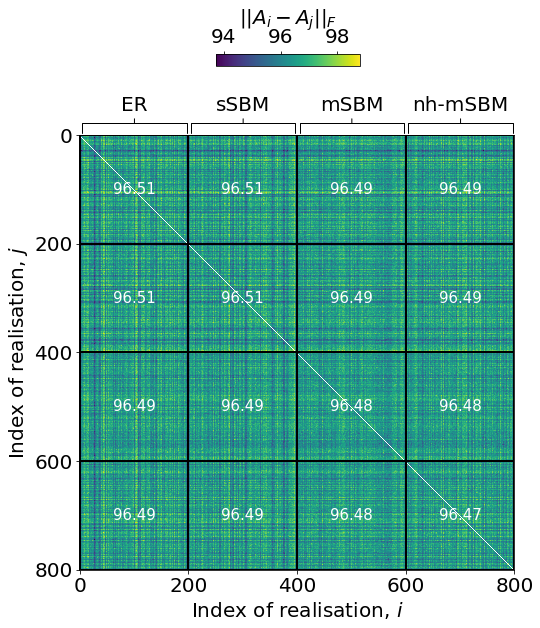

In [12]:
# load pairwise Frobenius distances
F = np.load(root_data+"results_comparison_frobenius.npy")

for i in range(F.shape[0]):
    F[i,i] = np.NaN

# compute mean values for each group
F_mean = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        F_mean[i,j] = np.around(np.nanmean(F[i*200:(i+1)*200,j*200:(j+1)*200]),2)


fig, ax = plt.subplots(1,figsize =(10,8))
im = ax.matshow(F)
# Add grid lines every 200 units
plt.grid(which='both', color='black', linewidth=2)
ax.set(xlabel="Index of realisation, $i$", ylabel="Index of realisation, $j$",xticks=np.arange(0,801,200),xticklabels=np.arange(0,801,200),yticks=np.arange(0,801,200),yticklabels=np.arange(0,801,200))

ax.xaxis.set_label_position('bottom')
ax.xaxis.set_ticks_position('bottom')

# Add curly brackets to the x-axis
for j in range(4):
    model_name = ["ER","sSBM","mSBM","nh-mSBM"]
    ax.annotate(model_name[j], xy=(55+j*108.7,445), xycoords='axes points',
                xytext=(0, 10), ha='center', va='bottom', textcoords='offset points',
                arrowprops=dict(arrowstyle='-[, widthB=2.61, lengthB=.5'))

# Add text annotations at the center of each block
for i in range(4):
    for j in range(4):
        block_num = i*4 + j + 1
        plt.text(j*200 + 100, i*200 + 100, F_mean[i,j], color='white',
                 ha='center', va='center', fontsize=15)


label_cbar = "$||A_i-A_j||_F$"

cbar_width = 0.2 
cbar_height = 0.02 
cbar_left = 0.5 - cbar_width / 2
cbar_ax = fig.add_axes([cbar_left, 1, cbar_width, cbar_height]) 
cbar = plt.colorbar(im,cax=cbar_ax,shrink = 0.4, label = label_cbar, location='top')
cbar.ax.xaxis.set_major_locator(MaxNLocator(3))

plt.savefig(root_fig +f'ensemble_frobenius.svg', dpi=fig.dpi,bbox_inches='tight')

# Statistical analysis of pairwise distances

We apply the *Wilcoxon signed-rank test* to test whether the mean pairwise distances within each ensemble are significantly different from the mean pairwise distances across different ensembles. To correct for multiple hypothesis testing we also apply the Benjaminini-Yekutieli correction.

In [3]:
from scipy.stats import wilcoxon
from scipy.stats import false_discovery_control

The difference is not significant for the Frobenius distance, which does not allow to distinguish the models.

In [53]:
print("Significance to distinguish Frobenius distances:\n")

F = np.load(root_data+"results_comparison_frobenius.npy")

# we ignore the values on the diagonal
for i in range(F.shape[0]):
    F[i,i] = np.nan

# apply Wilcoxon signed-rank test
s_0, p_0 = wilcoxon(np.nanmean(F[:200,:200],axis=0),F[:200,200:400].mean(axis=0),alternative='less',method="exact")
s_1, p_1 = wilcoxon(np.nanmean(F[:200,:200],axis=0),F[:200,400:600].mean(axis=0),alternative='less',method="exact")
s_2, p_2 = wilcoxon(np.nanmean(F[:200,:200],axis=0),F[:200,600:800].mean(axis=0),alternative='less',method="exact")
s_3, p_3 = wilcoxon(np.nanmean(F[200:400,200:400],axis=0),F[200:400,:200].mean(axis=0),alternative='less',method="exact")
s_4, p_4 = wilcoxon(np.nanmean(F[200:400,200:400],axis=0),F[200:400,400:600].mean(axis=0),alternative='less',method="exact")
s_5, p_5 = wilcoxon(np.nanmean(F[200:400,200:400],axis=0),F[200:400,600:800].mean(axis=0),alternative='less',method="exact")
s_6, p_6 = wilcoxon(np.nanmean(F[400:600,400:600],axis=0),F[400:600,:200].mean(axis=0),alternative='less',method="exact")
s_7, p_7 = wilcoxon(np.nanmean(F[400:600,400:600],axis=0),F[400:600,200:400].mean(axis=0),alternative='less',method="exact")
s_8, p_8 = wilcoxon(np.nanmean(F[400:600,400:600],axis=0),F[400:600,600:800].mean(axis=0),alternative='less',method="exact")
s_9, p_9 = wilcoxon(np.nanmean(F[600:800,600:800],axis=0),F[600:800,:200].mean(axis=0),alternative='less',method="exact")
s_10, p_10 = wilcoxon(np.nanmean(F[600:800,600:800],axis=0),F[600:800,200:400].mean(axis=0),alternative='less',method="exact")
s_11, p_11 = wilcoxon(np.nanmean(F[600:800,600:800],axis=0),F[600:800,400:600].mean(axis=0),alternative='less',method="exact")

# initialise p-values
ps = np.array([p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11])

# initialise statistics
statistics = np.array([s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11])

# correct p-values for multiple hypothesis testing using Benjamini-Hochberg 
ps_bh = false_discovery_control(ps, method="by")

# print corrected p-values
print('ER-ER vs. ER-sSBM                p =', ps_bh[0], ", sum of the ranks of the differences above or below zero =", statistics[0])
print('ER-ER vs. ER-mSBM                p =', ps_bh[1], ", sum of the ranks of the differences above or below zero =", statistics[1])
print('ER-ER vs. ER-nhmSBM              p =', ps_bh[2], ", sum of the ranks of the differences above or below zero =", statistics[2])
print('sSBM-sSBM vs. ER-sSBM            p =', ps_bh[3], ", sum of the ranks of the differences above or below zero =", statistics[3])
print('sSBM-sSBM vs. sSBM-mSBM          p =', ps_bh[4], ", sum of the ranks of the differences above or below zero =", statistics[4])
print('sSBM-sSBM vs. sSBM-nhmSBM        p =', ps_bh[5], ", sum of the ranks of the differences above or below zero =", statistics[5])
print('mSBM-mSBM vs. ER-mSBM            p =', ps_bh[6], ", sum of the ranks of the differences above or below zero =", statistics[6])
print('mSBM-mSBM vs. sSBM-mSBM          p =', ps_bh[7], ", sum of the ranks of the differences above or below zero =", statistics[7])
print('mSBM-mSBM vs. mSBM-nhmSBM        p =', ps_bh[8], ", sum of the ranks of the differences above or below zero =", statistics[8])
print('nhmSBM-nhmSBM vs. ER-nhmSBM      p =', ps_bh[9], ", sum of the ranks of the differences above or below zero =", statistics[9])
print('nhmSBM-nhmSBM vs. sSBM-nhmSBM    p =', ps_bh[10], ",sum of the ranks of the differences above or below zero =", statistics[10])
print('nhmSBM-nhmSBM vs. mSBM-nhmSBM    p =', ps_bh[11], ",sum of the ranks of the differences above or below zero =", statistics[11])


Significance to distinguish Frobenius distances:

ER-ER vs. ER-sSBM                p = 1.0 , sum of the ranks of the differences above or below zero = 9968.0
ER-ER vs. ER-mSBM                p = 1.0 , sum of the ranks of the differences above or below zero = 10330.0
ER-ER vs. ER-nhmSBM              p = 1.0 , sum of the ranks of the differences above or below zero = 10348.0
sSBM-sSBM vs. ER-sSBM            p = 1.0 , sum of the ranks of the differences above or below zero = 10281.0
sSBM-sSBM vs. sSBM-mSBM          p = 1.0 , sum of the ranks of the differences above or below zero = 10850.0
sSBM-sSBM vs. sSBM-nhmSBM        p = 1.0 , sum of the ranks of the differences above or below zero = 10762.0
mSBM-mSBM vs. ER-mSBM            p = 1.0 , sum of the ranks of the differences above or below zero = 9741.0
mSBM-mSBM vs. sSBM-mSBM          p = 1.0 , sum of the ranks of the differences above or below zero = 9308.0
mSBM-mSBM vs. mSBM-nhmSBM        p = 1.0 , sum of the ranks of the differences ab

However, the difference is significant for the 2-Wasserstein distance of both zero- and one-dimensional PDs.

In [54]:
print("Significance to distinguish 0-dim. Wasserstein distances (within ensemble smaller):\n")

wasserstein_distances = np.load(root_data+"results_comparison_wasserstein.npy")
W = wasserstein_distances[:,:,0]

# we ignore the values on the diagonal
for j in range(W.shape[0]):
        W[j,j] = np.nan

# apply Wilcoxon signed-rank test
s_0, p_0 = wilcoxon(np.nanmean(W[:200,:200],axis=0),W[:200,200:400].mean(axis=0),alternative='less',method="exact")
s_1, p_1 = wilcoxon(np.nanmean(W[:200,:200],axis=0),W[:200,400:600].mean(axis=0),alternative='less',method="exact")
s_2, p_2 = wilcoxon(np.nanmean(W[:200,:200],axis=0),W[:200,600:800].mean(axis=0),alternative='less',method="exact")
s_3, p_3 = wilcoxon(np.nanmean(W[200:400,200:400],axis=0),W[200:400,:200].mean(axis=0),alternative='less',method="exact")
s_4, p_4 = wilcoxon(np.nanmean(W[200:400,200:400],axis=0),W[200:400,400:600].mean(axis=0),alternative='less',method="exact")
s_5, p_5 = wilcoxon(np.nanmean(W[200:400,200:400],axis=0),W[200:400,600:800].mean(axis=0),alternative='less',method="exact")
s_6, p_6 = wilcoxon(np.nanmean(W[400:600,400:600],axis=0),W[400:600,:200].mean(axis=0),alternative='less',method="exact")
s_7, p_7 = wilcoxon(np.nanmean(W[400:600,400:600],axis=0),W[400:600,200:400].mean(axis=0),alternative='less',method="exact")
s_8, p_8 = wilcoxon(np.nanmean(W[400:600,400:600],axis=0),W[400:600,600:800].mean(axis=0),alternative='less',method="exact")
s_9, p_9 = wilcoxon(np.nanmean(W[600:800,600:800],axis=0),W[600:800,:200].mean(axis=0),alternative='less',method="exact")
s_10, p_10 = wilcoxon(np.nanmean(W[600:800,600:800],axis=0),W[600:800,200:400].mean(axis=0),alternative='less',method="exact")
s_11, p_11 = wilcoxon(np.nanmean(W[600:800,600:800],axis=0),W[600:800,400:600].mean(axis=0),alternative='less',method="exact")

# initialise p-values
ps = np.array([p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11])

# initialise statistics
statistics = np.array([s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11])

# correct p-values for multiple hypothesis testing using Benjamini-Hochberg 
ps_bh = false_discovery_control(ps, method="by")

# print corrected p-values
print('ER-ER vs. ER-sSBM                p =', ps_bh[0], ", sum of the ranks of the differences above zero =", statistics[0])
print('ER-ER vs. ER-mSBM                p =', ps_bh[1], ", sum of the ranks of the differences above zero =", statistics[1])
print('ER-ER vs. ER-nhmSBM              p =', ps_bh[2], ", sum of the ranks of the differences above zero =", statistics[2])
print('sSBM-sSBM vs. ER-sSBM            p =', ps_bh[3], ", sum of the ranks of the differences above zero =", statistics[3])
print('sSBM-sSBM vs. sSBM-mSBM          p =', ps_bh[4], ", sum of the ranks of the differences above zero =", statistics[4])
print('sSBM-sSBM vs. sSBM-nhmSBM        p =', ps_bh[5], ", sum of the ranks of the differences above zero =", statistics[5])
print('mSBM-mSBM vs. ER-mSBM            p =', ps_bh[6], ", sum of the ranks of the differences above zero =", statistics[6])
print('mSBM-mSBM vs. sSBM-mSBM          p =', ps_bh[7], ", sum of the ranks of the differences above zero =", statistics[7])
print('mSBM-mSBM vs. mSBM-nhmSBM        p =', ps_bh[8], ", sum of the ranks of the differences above zero =", statistics[8])
print('nhmSBM-nhmSBM vs. ER-nhmSBM      p =', ps_bh[9], ", sum of the ranks of the differences above zero =", statistics[9])
print('nhmSBM-nhmSBM vs. sSBM-nhmSBM    p =', ps_bh[10], ", sum of the ranks of the differences above zero =", statistics[10])
print('nhmSBM-nhmSBM vs. mSBM-nhmSBM    p =', ps_bh[11], ", sum of the ranks of the differences above zero =", statistics[11])


Significance to distinguish 0-dim. Wasserstein distances (within ensemble smaller):

ER-ER vs. ER-sSBM                p = 1.0533750004518834e-09 , sum of the ranks of the differences above zero = 5128.0
ER-ER vs. ER-mSBM                p = 1.1586796476556131e-59 , sum of the ranks of the differences above zero = 0.0
ER-ER vs. ER-nhmSBM              p = 1.7380194714834197e-59 , sum of the ranks of the differences above zero = 2.0
sSBM-sSBM vs. ER-sSBM            p = 5.92934422360887e-22 , sum of the ranks of the differences above zero = 2684.0
sSBM-sSBM vs. sSBM-mSBM          p = 1.1586796476556131e-59 , sum of the ranks of the differences above zero = 0.0
sSBM-sSBM vs. sSBM-nhmSBM        p = 2.9291421492733898e-56 , sum of the ranks of the differences above zero = 39.0
mSBM-mSBM vs. ER-mSBM            p = 3.2443030134357167e-59 , sum of the ranks of the differences above zero = 4.0
mSBM-mSBM vs. sSBM-mSBM          p = 1.7380194714834197e-59 , sum of the ranks of the differences above z

In [52]:
print("Significance to distinguish 1-dim. Wasserstein distances (within ensemble smaller):\n")

wasserstein_distances = np.load(root_data+"results_comparison_wasserstein.npy")
W = wasserstein_distances[:,:,1]


# we ignore the values on the diagonal
for j in range(W.shape[0]):
        W[j,j] = np.nan



# apply Wilcoxon signed-rank test
s_0, p_0 = wilcoxon(np.nanmean(W[:200,:200],axis=0),W[:200,200:400].mean(axis=0),alternative='less',method="exact")
s_1, p_1 = wilcoxon(np.nanmean(W[:200,:200],axis=0),W[:200,400:600].mean(axis=0),alternative='less',method="exact")
s_2, p_2 = wilcoxon(np.nanmean(W[:200,:200],axis=0),W[:200,600:800].mean(axis=0),alternative='less',method="exact")
s_3, p_3 = wilcoxon(np.nanmean(W[200:400,200:400],axis=0),W[200:400,:200].mean(axis=0),alternative='less',method="exact")
s_4, p_4 = wilcoxon(np.nanmean(W[200:400,200:400],axis=0),W[200:400,400:600].mean(axis=0),alternative='less',method="exact")
s_5, p_5 = wilcoxon(np.nanmean(W[200:400,200:400],axis=0),W[200:400,600:800].mean(axis=0),alternative='less',method="exact")
s_6, p_6 = wilcoxon(np.nanmean(W[400:600,400:600],axis=0),W[400:600,:200].mean(axis=0),alternative='less',method="exact")
s_7, p_7 = wilcoxon(np.nanmean(W[400:600,400:600],axis=0),W[400:600,200:400].mean(axis=0),alternative='less',method="exact")
s_8, p_8 = wilcoxon(np.nanmean(W[400:600,400:600],axis=0),W[400:600,600:800].mean(axis=0),alternative='less',method="exact")
s_9, p_9 = wilcoxon(np.nanmean(W[600:800,600:800],axis=0),W[600:800,:200].mean(axis=0),alternative='less',method="exact")
s_10, p_10 = wilcoxon(np.nanmean(W[600:800,600:800],axis=0),W[600:800,200:400].mean(axis=0),alternative='less',method="exact")
s_11, p_11 = wilcoxon(np.nanmean(W[600:800,600:800],axis=0),W[600:800,400:600].mean(axis=0),alternative='less',method="exact")

# initialise p-values
ps = np.array([p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,p_10,p_11])

# initialise statistics
statistics = np.array([s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,s_11])

# correct p-values for multiple hypothesis testing using Benjamini-Hochberg 
ps_bh = false_discovery_control(ps, method="by")

# print corrected p-values
print('ER-ER vs. ER-sSBM                p =', ps_bh[0], ", sum of the ranks of the differences above zero =", statistics[0])
print('ER-ER vs. ER-mSBM                p =', ps_bh[1], ", sum of the ranks of the differences above zero =", statistics[1])
print('ER-ER vs. ER-nhmSBM              p =', ps_bh[2], ", sum of the ranks of the differences above zero =", statistics[2])
print('sSBM-sSBM vs. ER-sSBM            p =', ps_bh[3], ", sum of the ranks of the differences above zero =", statistics[3])
print('sSBM-sSBM vs. sSBM-mSBM          p =', ps_bh[4], ", sum of the ranks of the differences above zero =", statistics[4])
print('sSBM-sSBM vs. sSBM-nhmSBM        p =', ps_bh[5], ", sum of the ranks of the differences above zero =", statistics[5])
print('mSBM-mSBM vs. ER-mSBM            p =', ps_bh[6], ", sum of the ranks of the differences above zero =", statistics[6])
print('mSBM-mSBM vs. sSBM-mSBM          p =', ps_bh[7], ", sum of the ranks of the differences above zero =", statistics[7])
print('mSBM-mSBM vs. mSBM-nhmSBM        p =', ps_bh[8], ", sum of the ranks of the differences above zero =", statistics[8])
print('nhmSBM-nhmSBM vs. ER-nhmSBM      p =', ps_bh[9], ", sum of the ranks of the differences above zero =", statistics[9])
print('nhmSBM-nhmSBM vs. sSBM-nhmSBM    p =', ps_bh[10], ", sum of the ranks of the differences above zero =", statistics[10])
print('nhmSBM-nhmSBM vs. mSBM-nhmSBM    p =', ps_bh[11], ", sum of the ranks of the differences above zero =", statistics[11])


Significance to distinguish 1-dim. Wasserstein distances (within ensemble smaller):

ER-ER vs. ER-sSBM                p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
ER-ER vs. ER-mSBM                p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
ER-ER vs. ER-nhmSBM              p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
sSBM-sSBM vs. ER-sSBM            p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
sSBM-sSBM vs. sSBM-mSBM          p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
sSBM-sSBM vs. sSBM-nhmSBM        p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
mSBM-mSBM vs. ER-mSBM            p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
mSBM-mSBM vs. sSBM-mSBM          p = 2.317359295311226e-60 , sum of the ranks of the differences above zero = 0.0
mSB